There are a lot of intangible features that are used to judge whether a player will do well in the NFL. However, with so many different players out there, it would be helpful to scouts to have a way of narrowing the list of potential players down. According to scouting developer Dan Hatman, "scouts typically are left to sink or swim, and I [Dan] for one, spent the first couple of years just trying to keep my [his] head above water." (source: https://www.scoutingacademy.com/The-Source/SourceID/1126/The-Why) A great source of attempting to narrow down the pool of potential players has been the use of computers to sift through data, as former scout Gil Brandt demonstrated in the 1960's:

"His [Gil Brandt's] IBM 360 computer system, which weighted prospects' attributes and helped organize the Cowboys' draft board, began to gain widespread popularity after initially serving as a punching bag for the old guard. Vince Lombardi once called him out at an NFL draft ... and a year or two later, asked him how to use one." (scoure: http://www.nfl.com/historyofscouting)

[For those who don't know much about American football, Vince Lombardi is the man that the annual championship trophy is named after.]

Our analysis today will see how successfully someone with limited access to college statistics can predict if a player should be considered for the NFL draft. Note that we are attempting this without nearly as much data as professional scouts, and as such we may be at a disadvantage. Our goal is to use data science in order to creating a model that will assist National Football League (NFL) Scouting offices narrow down which running backs to spend more time scouting. The model that we create will use college football data in order to determine which college running backs are likely of making it into the NFL. 

## Data Wrangling

The first step in our process is data wrangling. This is where we collect our data and 'clean' it, i.e. make sure that it is in a useable form for our model. While we will only show a segment of the process, the whole code can be found here:

http://localhost:8888/notebooks/!Springboard%20Material/Capstone%201/Data%20Wrangling%20and%20Web%20Scraping.ipynb

There are two different sets of data we will need: college football statistics and NFL statistics. We have obtained our college football statistics from http://www.footballdb.com/college-football/stats/stats.html?yr=2015&conf=&mode=R. These only go as far back as 2009, which does put a limit on our amount of available data. For these tables, we simply copied and pasted them into Excel spreadsheets and saved those spreadsheets as CSV files. Before we collect our NFL data, we should make sure that our college data frames are useable by our model first. We have already done this with each year, but we will use 2009 as our demonstration here.

We start by importing the necessary libraries. This will allow us to turn our saved CSV files into data frames, which is the form which allows us to easily interact with the data. 

In [1]:
# Import the pandas module so that we may use data frames, and the numpy module 
# so that we may use NaNs. 
import pandas as pd
import numpy as np

# Imports the data from our CSV file into a data frame, which we can perform data
# analysis on.
cf_09 = pd.DataFrame.from_csv('data/College_FB_2009.csv', index_col=None, encoding='utf-8')
# The source of this data represents missing values with '--', so we need to 
# transform them to NaNs for us to count.
cf_09 = cf_09.replace('--', np.nan)
cf_09.head()

,Player,Team,Att,Gain,Loss,Yds,Avg,Lg,TD
0,Toby Gerhart,STAN,343.0,1913.0,42.0,1871.0,5.45,NaN,28.0
1,Ryan Mathews,FRES,276.0,1850.0,42.0,1808.0,6.55,NaN,19.0
2,Dion Lewis,PITT,325.0,1862.0,63.0,1799.0,5.54,NaN,17.0
3,Mark Ingram,ALA,271.0,1678.0,20.0,1658.0,6.12,NaN,17.0
4,Ryan Williams,VT,293.0,1720.0,65.0,1655.0,5.65,NaN,21.0


We do not have access to nearly as many features as we would like. Professional scouts would normally have access to information on speed, strength, height, weight, and potentially other factors when making their determinations and creating their predictive models. Unfortunately, this was the most complete data set we could find that was free. 

Now that we have our data in a data frame, we can determine what percentage of each column has missing values

In [2]:
# We want to count the number of null values in the cf_09 data frame. 
cf_09_c = cf_09.copy()
c = cf_09_c.isnull().sum().sort_values(ascending = False)/len(cf_09_c.index)
c

Lg        1.0
TD        0.0
Avg       0.0
Yds       0.0
Loss      0.0
Gain      0.0
Att       0.0
Team      0.0
Player    0.0
dtype: float64

From this, we can see that the only missing information is the longest run that each player had. While this would have been a nice feature to have, we can consider the data as acceptably clean since all of our missing values come from a single column. 

With the volume of data available for NFL running backs, we need to utilize a different approach than a simple copy/paste. For our NFL data, we will implement a process known as web scraping. This is where we write a program that goes to the web sites we are interested in and pulls the information off of the page and into a data frame, navigating around the sites as necessary. We will pull our NFL data from http://www.nfl.com/stats/categorystats?archive=true&conference=null&statisticCategory=RUSHING&season=2016&seasonType=REG&experience=&tabSeq=0&qualified=false&Submit=Go. Our code will demonstrate only our data collection for 2010, but this does need to be done for every year. We start with 2010 because our first year of college football data was 2009. 

An important note on web scraping: this process uses the html code of a web site to determine where to find its information. However, that code is subject to change. Because of this, the following code may no longer function as intended due to certain elements of the html code changing. If this is the case, skip this step and use the CSV files in the data folder here https://github.com/Dracoback/NFL-Rookie-Running-Back-Analysis for the already scraped versions.

In [3]:
# Imports webdriver from the selenium module. This will allow our code to 
# access the internet using a separate pop-up browser.
from selenium import webdriver
# It is important to note that we would normally need to import both pandas 
# and numpy here as well. However, we have done this in an earlier code block, 
# so we do not need to do it again now. 

# Open up the first page for the year we are working on.
browser = webdriver.Chrome()
browser.get('http://www.nfl.com/stats/categorystats?archive=true&conference=null&statisticPositionCategory=RUNNING_BACK&season=2010&seasonType=REG&experience=&tabSeq=1&qualified=true&Submit=Go')

# Create an empty data frame and create column headers.
df = pd.DataFrame()
column_headers = ['Rk', 'Player', 'Team', 'Pos', 'Att', 'Att/G', 'Yds', 'Avg', 'Yds/G', 'TD', 'Long', '1st Downs', '1st Down %', '20+', '40+', 'FUM']

# This loop will find all of the elements in the table, put them into a list
# and then add them to our data frame, then navigate to the next page. 
while(True):
    # The 'td' was selected because this is the html tag that specifies all 
    # table entries on our web page.
    elems = browser.find_elements_by_tag_name('td')
    # Creates an empty list to put all found elements in.
    myList = list()
    i = 0
    while (i < len(elems)):
        myList.append(elems[i].text)
        i = i + 1
    # We create rows this way so that we have the correct number of rows (the 
    # last page may not have the same number of rows as the other pages). There
    # are 16 columns, which is why we use 16. Then we create a temporary data 
    # frame to concatonate with our final data frame.
    rows = int(len(myList)/16)
    dftemp = pd.DataFrame(np.array(myList).reshape(rows,16), columns = column_headers)
    df = pd.concat([df, dftemp])
    # Every page except the last one has a button labeled 'next' that navigates
    # to the next page. Once we have the exception, we know we have finished 
    # with the last page, and so the loop breaks.
    try:
        linkElem = browser.find_element_by_link_text('next')
        linkElem.click()
    except: 
        break
        
# This prints out the data frame so that we may manually check that we received 
# the correct number of entries.
df

,Rk,Player,Team,Pos,Att,Att/G,Yds,Avg,Yds/G,TD,Long,1st Downs,1st Down %,20+,40+,FUM
0,1,Arian Foster,HOU,RB,327,20.4,"1,616",4.9,101.0,16,74T,89,27.2,12,3,3
1,2,Maurice Jones-Drew,JAC,RB,299,21.4,"1,324",4.4,94.6,5,37,75,25.1,8,0,2
2,3,Jamaal Charles,KC,RB,230,14.4,"1,467",6.4,91.7,5,80,70,30.4,10,3,2
3,4,Darren McFadden,OAK,RB,223,17.2,"1,157",5.2,89.0,7,57T,45,20.2,14,4,3
4,5,Adrian Peterson,MIN,RB,283,18.9,"1,298",4.6,86.5,12,80T,70,24.7,9,2,1
5,6,Michael Turner,ATL,RB,334,20.9,"1,371",4.1,85.7,12,55,71,21.3,9,1,2
6,7,Chris Johnson,TEN,RB,316,19.8,"1,364",4.3,85.2,11,76T,55,17.4,13,4,2
7,8,Rashard Mendenhall,PIT,RB,324,20.2,"1,273",3.9,79.6,13,50T,61,18.8,11,1,2
8,9,Steven Jackson,STL,RB,330,20.6,"1,241",3.8,77.6,6,42T,60,18.2,7,1,1
9,10,Frank Gore,SF,RB,203,18.5,853,4.2,77.5,3,64,42,20.7,6,1,3


After checking that we imported all of the players (which we can do manually by observing the size of the final data frame and by navigating to our web site and looking at the number for the last player), we should save our data frame as a CSV file so that we can use later. We have done this prior, so our line is commented out.

In [4]:
# This converts our data frame into a csv file. 
# df.to_csv('data/NFL_Pro_2010.csv', index = False)

From here, it is important that we once again check for missing values.

In [5]:
# Typically we would have the same import statements here as our previous attempts
# at checking for nulls. However, since we have already imported our necessary 
# modules earlier, we can leave the import statements out of this code block.

npro_10 = pd.DataFrame.from_csv('data/NFL_Pro_2010.csv', index_col=None, encoding='utf-8')
npro_10 = npro_10.replace('--', np.nan)
npro_10_c = npro_10.copy()
npro = npro_10_c.isnull().sum().sort_values(ascending = False)/len(npro_10_c.index)
npro

FUM           0.0
40+           0.0
20+           0.0
1st Down %    0.0
1st Downs     0.0
Long          0.0
TD            0.0
Yds/G         0.0
Avg           0.0
Yds           0.0
Att/G         0.0
Att           0.0
Pos           0.0
Team          0.0
Player        0.0
Rk            0.0
dtype: float64

Now that we have observed that there are indeed no missing values, we can merge all of our data frames to continue to prepare ourselves for analysis. As we merge our data frames and begin our data analysis, the full version of this portion of the code can be found here: https://github.com/Dracoback/NFL-Rookie-Running-Back-Analysis/blob/master/Merging%20DataFrames%20and%20Data%20Storytelling.ipynb

We will import both the college football and NFL statistics from each of our years into a single data frame for each of them.

In [6]:
from glob import glob

#Imports each year of college football statistics.
dataframes = [pd.read_csv(file) for file in glob('data/College_FB_*.csv')]

# Merges together all of the dataframes into one college dataframe. 
dataframes[0]['Year'] = '2009'
for i in range(1, len(dataframes)):
    dataframes[i]['Year'] = '20' + str(i+9)
college_fb_df = dataframes[0]
college_fb_df = np.vstack([college_fb_df, dataframes[1]])
for i in range(2,len(dataframes)):
    college_fb_df = np.vstack([college_fb_df, dataframes[i]])

college_fb_df = pd.DataFrame(college_fb_df, columns=dataframes[0].columns)
college_fb_df.head()

,Player,Team,Att,Gain,Loss,Yds,Avg,Lg,TD,Year
0,Toby Gerhart,STAN,343,1913,42,1871,5.45,--,28,2009
1,Ryan Mathews,FRES,276,1850,42,1808,6.55,--,19,2009
2,Dion Lewis,PITT,325,1862,63,1799,5.54,--,17,2009
3,Mark Ingram,ALA,271,1678,20,1658,6.12,--,17,2009
4,Ryan Williams,VT,293,1720,65,1655,5.65,--,21,2009


In [7]:
#Imports each year of NFL statistics.
dataframes = [pd.read_csv(file) for file in glob('data/NFL_Pro_*.csv')]
# Merges together all of the dataframes into one NFL dataframe. 
for i in range(0, len(dataframes)):
    dataframes[i]['Year'] = '20' + str(i+10)
nfl_fb_df = dataframes[0]
nfl_fb_df = np.vstack([nfl_fb_df, dataframes[1]])
for i in range(2,len(dataframes)):
    nfl_fb_df = np.vstack([nfl_fb_df, dataframes[i]])

nfl_fb_df = pd.DataFrame(nfl_fb_df, columns=dataframes[0].columns)
nfl_fb_df.head()

,Rk,Player,Team,Pos,Att,Att/G,Yds,Avg,Yds/G,TD,Long,1st Downs,1st Down %,20+,40+,FUM,Year
0,1,Arian Foster,HOU,RB,327,20.4,"1,616",4.9,101,16,74T,89,27.2,12,3,3,2010
1,2,Maurice Jones-Drew,JAC,RB,299,21.4,"1,324",4.4,94.6,5,37,75,25.1,8,0,2,2010
2,3,Jamaal Charles,KC,RB,230,14.4,"1,467",6.4,91.7,5,80,70,30.4,10,3,2,2010
3,4,Darren McFadden,OAK,RB,223,17.2,"1,157",5.2,89,7,57T,45,20.2,14,4,3,2010
4,5,Adrian Peterson,MIN,RB,283,18.9,"1,298",4.6,86.5,12,80T,70,24.7,9,2,1,2010


Our analysis is going to end up focusing on the numerical averages of our statistics. Before we can compute these statistics, we will need to make sure that our numeric columns actually contain numbers instead of strings. 

In [8]:
# Transform our numeric columns from strings into floats. 
nfl_fb_df['Yds'] = nfl_fb_df['Yds'].str.replace(',','')
for col in nfl_fb_df.columns:
    if col not in ['Player','Team','Pos','Long']:
        nfl_fb_df[col] = nfl_fb_df[col].astype('float')

for col in college_fb_df.columns:
    if col not in ['Player','Team','Pos','Lg']:
        college_fb_df[col] = college_fb_df[col].astype('float')

Another important step is to make sure that we do not include any college players in our anaylsis who have not yet graduated. We can do this by omitting any players who have 2016 college information, as they are guaranteed to not yet have any NFL information.

In [9]:
clg_fb_not_done = college_fb_df[college_fb_df.Year == 2016]
college_fb_df = college_fb_df[college_fb_df.Year <= 2015]
drop_players = clg_fb_not_done['Player'].tolist()
college_fb_df = college_fb_df[~college_fb_df['Player'].isin(drop_players)]

We would like to have averages for the college and NFL players. We will create new data frames for these by grouping the columns by the player names and then finding the mean. Note that this will eliminate non-numeric information (with the exception of player names).

In [10]:
# Create dataframes for career averages.
college_avgs = college_fb_df.groupby(by='Player').mean()
nfl_avgs = nfl_fb_df.groupby(by='Player').mean()

# We delete the year columns because they are no longer important or useful.
del nfl_avgs['Year']
del college_avgs['Year']

Now that we have our averages, we should take a moment to visualize our information.

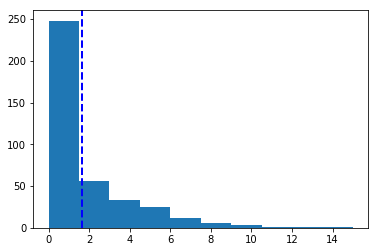

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(nfl_avgs['TD'], bins = 10)
plt.axvline(nfl_avgs['TD'].mean(), color='b', linestyle='dashed', linewidth=2);

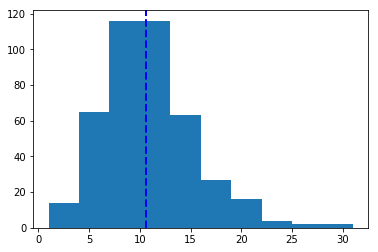

In [12]:
plt.hist(college_avgs['TD'], bins = 10)
plt.axvline(college_avgs['TD'].mean(), color='b', linestyle='dashed', linewidth=2);

Surprisingly, the NFL average on touchdowns (and most of the statistics) is low, with a majority of players below the average. The college averages, on the other hand, seem to resemble a bell curve much more closely. This demonstrates how much more difficult the NFL is than college football, and gives us inspiration to come back to this topic in the future to attempt to create a model that could determine if a player will be successful in the NFL based on their college statistics.

Now lets take a look at how many of our college players actually made it into the NFL by performing an inner join of our data frames.

In [13]:
college_avgs.shape

(425, 6)

In [14]:
nfl_avgs.shape

(386, 12)

In [15]:
# Creates a column for the averages to be merged on.
college_avgs['Player'] = college_avgs.index
nfl_avgs['Player'] = nfl_avgs.index

avgs_merged = pd.merge(college_avgs, nfl_avgs, on='Player', suffixes=['_College','_Pro'], how='inner')
avgs_merged.shape

(145, 19)

This innner join tells us a couple of things. 

The first thing it tells us is that of the 425 college running backs that we have information on, only 145 of them made it to the NFL, which is roughly 34.1%. This also tells us that from our 386 NFL players, we only have college information on 145 of them, which means we only have college statistics on roughly 37.6% of our NFL players. This may be due to information collected on older players who were playing in college before 2009. For example, Adrian Peterson played college football in 2004, so he is no a member of our inner join. Keeping this in mind, some of our college football data may be incomplete/incorrect if some of the earlier years were omitted, for example if a player's senior year was in 2009 and so we have missed out on their prior years.

Something that is disconcerting is that we only have 425 college players to make predictions with. While that may seem like a lot if we had to scout each individual player, this is not a large amount of data for our model to make predictions with. This will impact how we test our models, as we will see later.

Before we continue, we should make sure to save our current data frames as CSV files. 

In [16]:
college_avgs['Made NFL'] = college_avgs['Player'].isin(avgs_merged['Player'].values.tolist())
college_avgs.to_csv('college_avgs_clean.csv', index=False)
nfl_avgs.to_csv('nfl_avgs_clean.csv', index=False)
avgs_merged.to_csv('avgs_merged_clean.csv', index=False)

## Exploratory Data Analysis (EDA)

We will now begin the statistical exploratory data analysis (EDA). We will now look at a pair plot of the information to determine if we can discover any trends that lead to college players making it into the NFL.

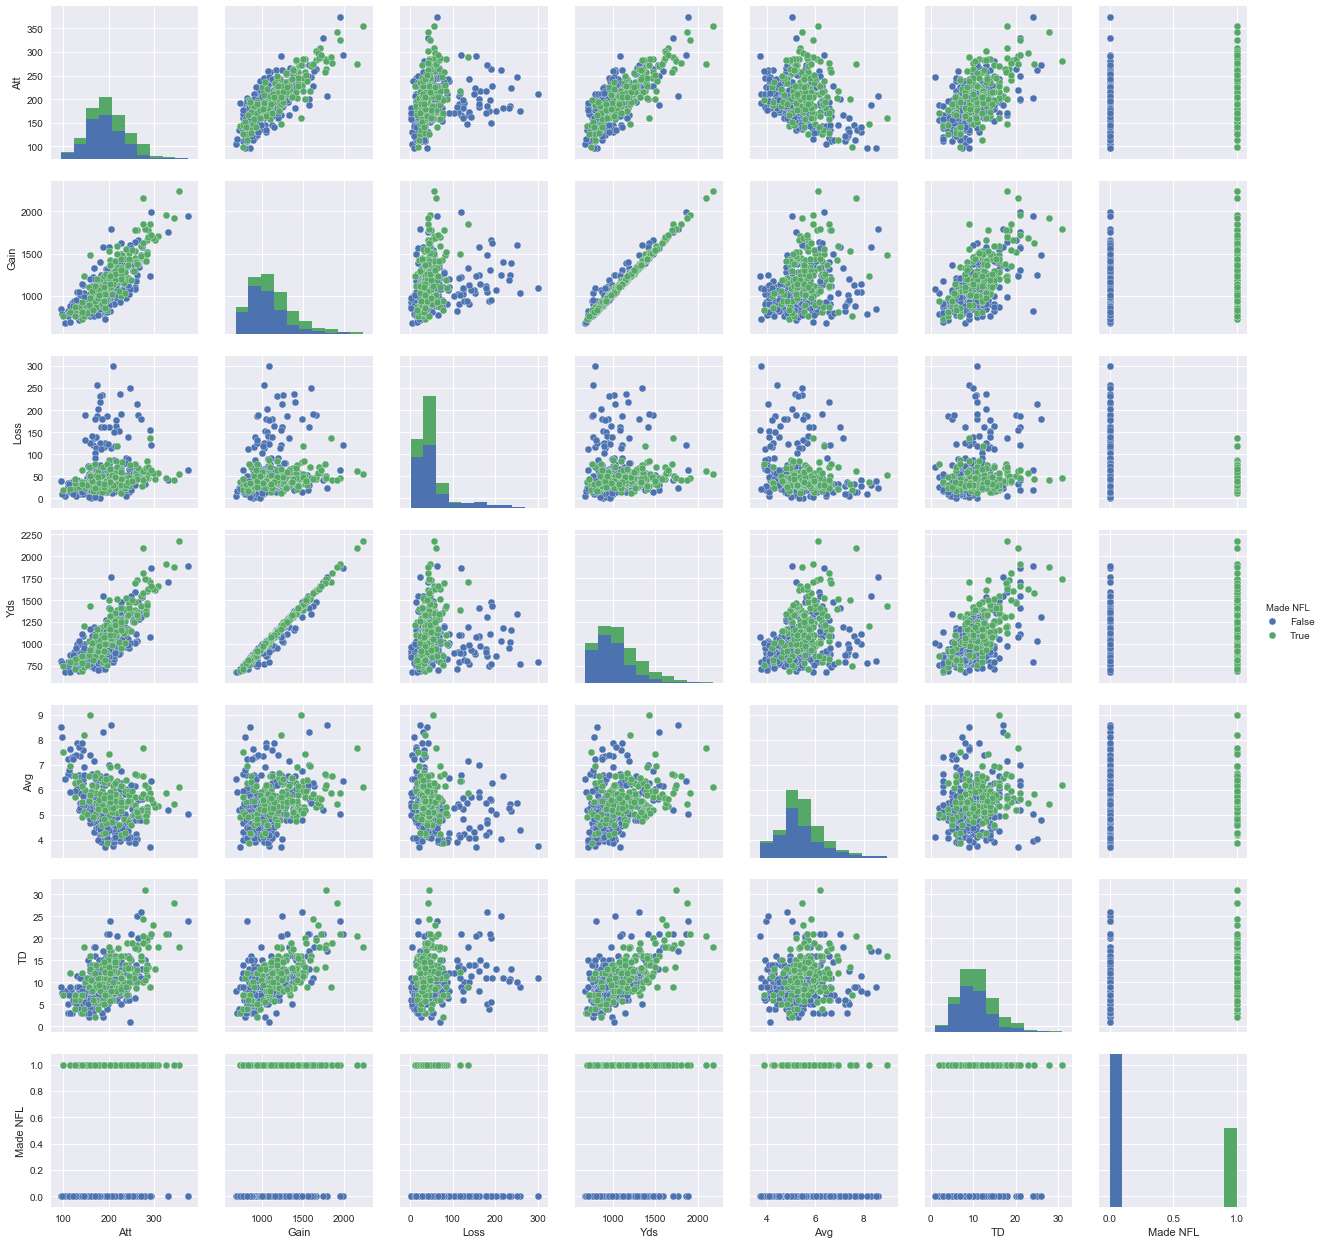

In [17]:
import seaborn as sns

sns.pairplot(college_avgs, hue='Made NFL')

The only noticable trend is that when a player has a large amount of negative (loss) yards in college, that player does not make it into the NFL. This is not a surprising result, as we would expect players who have a negative impact more frequently than others to not make it into the NFL. Hopefully our machine learning algorithms will uncover some less obvious trends. 

As we continue our statistical EDA, the full code for this section can be found here: https://github.com/Dracoback/NFL-Rookie-Running-Back-Analysis/blob/master/Statistical%20EDA.ipynb

In order to give our data frames clearer names, we will import our newly saved CSV files.

In [18]:
nfl = pd.read_csv('nfl_avgs_clean.csv')
clg = pd.read_csv('college_avgs_clean.csv')
avgs = pd.read_csv('avgs_merged_clean.csv')

One of the tools we can use to gain insight as to what features the model may choose to focus on is a heat map. This will allow us to quickly determine which of our features are correlated with whether or not a player makes it into the NFL. 

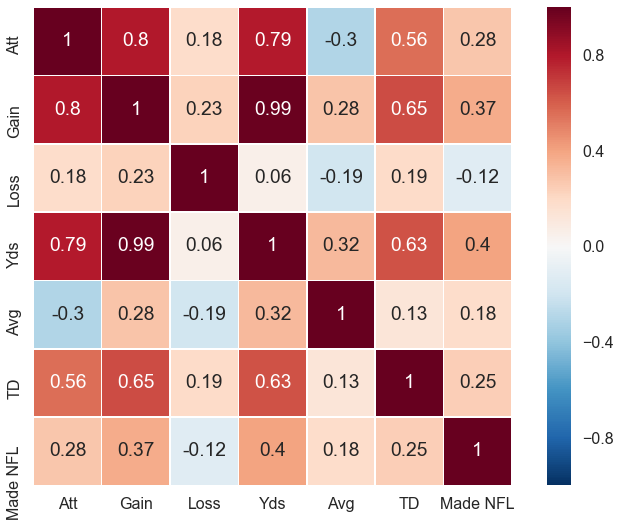

In [19]:
corr = clg.corr()
sns.set_context('poster') # Resizes the displayed visuals.
sns.heatmap(corr, annot = True,square = True, linewidths = .5);

This provides us with some interesting results. As expected, there was a negative correlation between making it into the NFL and having Loss yards. We are shown how strongly correlated the Gain and Yds columns are, but that is not surprising. While more attempts (Att) are strongly correlated with positive yards (Gain and Yds), it is negatively correlated with the average yards per attempt (Avg). In addition, positive yards are positively correlated with touchdowns, although that is not too surprising either. It seems that yards gained has the greatest positive correlation with making it into the NFL. 

## Machine Learning

Now that we have a sense of which features our model may deem the most important, we will move on to actual model creation. The full version of this portion of the code is available here: https://github.com/Dracoback/NFL-Rookie-Running-Back-Analysis/blob/master/Machine_Learning_Scoring_Metrics.ipynb

We wish to find a model that will allow us to determine which college running backs will likely make it into the NFL. We have two types of models that we will be using. The first type is called k-nearest-neighbors (knn), and it would determine whether or not new players made it into the NFL or not based on if a majority of the 'k' closest data points made it into the NFL or not. The second type is called a random forest, and it would determine if a new player makes it into the NFL or not by utilizing a number of randomly generated tree diagrams that would vote on if they believed the new player fit the correct criteria or not. Our models will give us a value of 'True' if they think we should scout a particular player, and 'False' if they think that we should pass on a particular player. 

There are two different metrics that our models will be attempting to optimize over: 'True' precision and 'True' recall. 

'True' precision says the following: "From the players that our model said we should scout, this is the percentage that we can expect to actually be worth looking at."

'True' recall says the following: "From the players that our model should have told us to scout, this is the percentage of them that we can expect to be looking at based on the model's recommendations."

If a team did not have a lot of scouting rescources, they would prefer models with a high amount of 'True' precision since this would tell them that most of the players they observe will be worthwhile in pursuing. If a team does have a lot of scouting resources, they would prefer models with a high amount of 'True' recall since this would tell them that they would not likely overlook a potential star player. 

We will do one last bit of preprocessing of our data. Since the player names are not needed by our model, we will drop them before performing our analysis.

In [20]:
clg = clg.drop('Player', axis=1)

Normally, we would want to have our training and test sets separately for our data. This would allow us to create a model with some of our data and test it with new data the model had never seen before. Unfortunately for us, we do not have a lot of data. As discussed by Sebastian Raschka, author of Python Machine Learning, it does not make much sense to hold out test data for creating our model. (sources: https://twitter.com/rasbt/status/955531741359460352 and https://twitter.com/rasbt/status/954882651613167616) Because we have so little data available, the model may vary greatly on how well it does based on which part of the data gets left out. As such, it is wiser to use all of our data with cross validation to make our predictions. 

There is still value, however, in splitting into training and testing data. This allows us to choose parameters for our models without overfitting to the best possible parameters for this data set. As such, we will still need a training set.

We will now split our data into training and testing sets, so that our models have some data that they can use to be created while leaving out other data so that they can be tested without bias. 

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y = clg['Made NFL'].values
X = clg.drop('Made NFL', axis=1).values
X_scaled = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=24, stratify=y)

We will start by using 'True' precision as our scoring metric. 

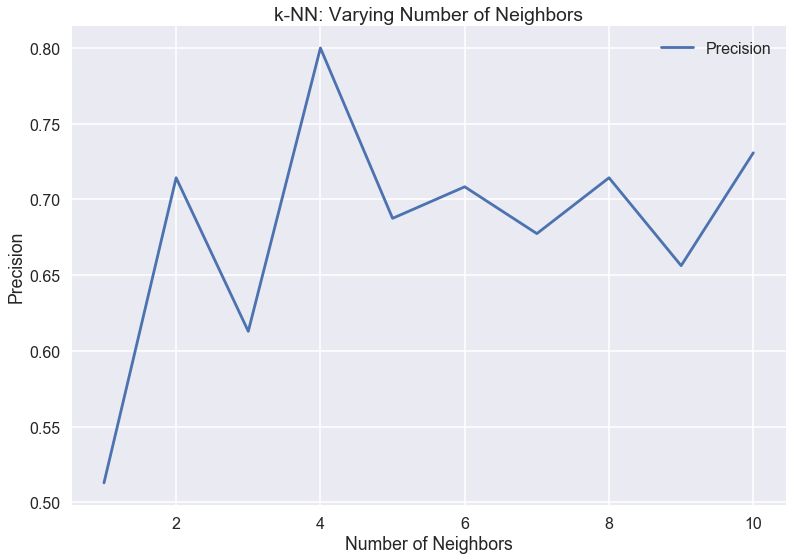

Optimal k =  4
Optimal knn Precision Score =  0.8
Optimal Random Forest Parameters:  {'class_weight': None, 'max_features': 1, 'min_samples_leaf': 9, 'n_estimators': 5}
Random Forest Precision Score:  0.693209876543
Confusion Matrix and Classification Report for Best KNN Classifier
[[236  44]
 [ 90  55]]
             precision    recall  f1-score   support

      False       0.72      0.84      0.78       280
       True       0.56      0.38      0.45       145

avg / total       0.67      0.68      0.67       425

Confusion Matrix and Classification Report for Best Random Forest Classifier
[[232  48]
 [ 76  69]]
             precision    recall  f1-score   support

      False       0.75      0.83      0.79       280
       True       0.59      0.48      0.53       145

avg / total       0.70      0.71      0.70       425



In [22]:
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_predict
neighbors = np.arange(1, 11)
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    # Compute different metric.
    y_test_pred = knn.predict(X_test)
    test_accuracy[i] = precision_score(y_test, y_test_pred)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Precision')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Precision')
plt.show()

print('Optimal k = ', test_accuracy.argmax()+1)
print('Optimal knn Precision Score = ', test_accuracy.max())

forest = RandomForestClassifier(random_state=42)
parameters = {'n_estimators':[1, 2, 3, 4, 5, 10],'min_samples_leaf':np.arange(1,21), 'class_weight':('balanced','balanced_subsample',None), 'max_features':np.arange(1,7)}

cv = GridSearchCV(forest, param_grid = parameters, scoring='precision')
cv.fit(X_train, y_train)
print('Optimal Random Forest Parameters: ', cv.best_params_)
print('Random Forest Precision Score: ', cv.best_score_)

knn = KNeighborsClassifier(n_neighbors = test_accuracy.argmax() + 1)
y_pred = cross_val_predict(knn, X, y)
print('Confusion Matrix and Classification Report for Best KNN Classifier')
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


print('Confusion Matrix and Classification Report for Best Random Forest Classifier')
model = cv.best_estimator_
y_pred = cross_val_predict(model, X, y)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

From our classification reports, we can see that using our knn model with "n-neighbors = 4" should provide us with our best 'True' precision at 80%, which means that most of our suggested scouting options will be worth looking at. However, when we perform cross-validation, we see that our Random Forest Classifier actually performs better in terms of precision, with a score of 59%. This is equivalent to saying "about 3 out of every 5 players the model tells us to look at will actually be worth looking at." We would like that number to be higher; in fact, the predicted 80% precision from the knn model would have been a much nicer number to have. While we would like to use this model to narrow the field of potential running backs that we scouted further, this model only has a 'True' recall of 48%, meaning that over half of the players we should scout further are skipped over.

Now we will use 'True' recall as our scoring metric.

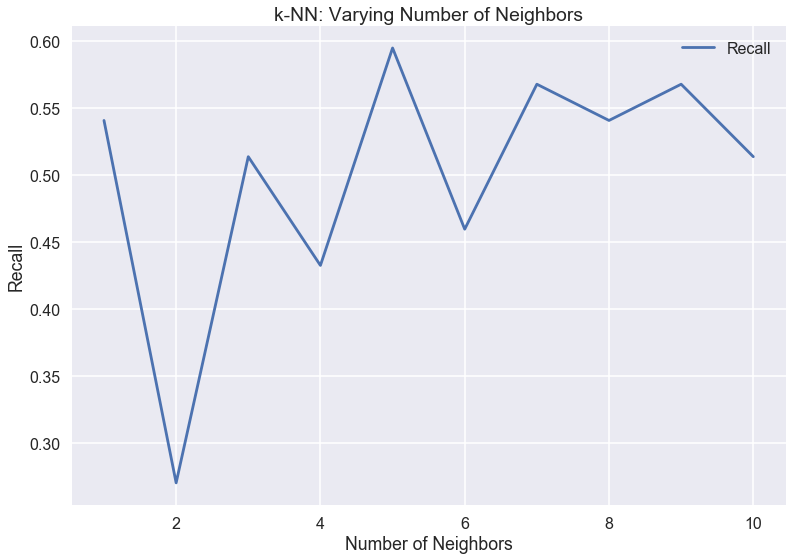

Optimal k =  5
Optimal knn Recall Score =  0.594594594595
Optimal Random Forest Parameters:  {'class_weight': 'balanced', 'max_features': 4, 'min_samples_leaf': 19, 'n_estimators': 1}
Optimal Random Forest Recall Score:  0.740740740741
Confusion Matrix and Classification Report for Best KNN Classifier
[[225  55]
 [ 68  77]]
             precision    recall  f1-score   support

      False       0.77      0.80      0.79       280
       True       0.58      0.53      0.56       145

avg / total       0.70      0.71      0.71       425

Confusion Matrix and Classification Report for Best Random Forest Classifier
[[181  99]
 [ 45 100]]
             precision    recall  f1-score   support

      False       0.80      0.65      0.72       280
       True       0.50      0.69      0.58       145

avg / total       0.70      0.66      0.67       425



In [23]:
from sklearn.metrics import recall_score
neighbors = np.arange(1, 11)
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute different metric.
    y_test_pred = knn.predict(X_test)
    test_accuracy[i] = recall_score(y_test, y_test_pred)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Recall')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Recall')
plt.show()

print('Optimal k = ', test_accuracy.argmax()+1)
print('Optimal knn Recall Score = ', test_accuracy.max())

forest = RandomForestClassifier(random_state=42)
parameters = {'n_estimators':[1, 2, 3, 4, 5, 10],'min_samples_leaf':np.arange(1,21), 'class_weight':('balanced','balanced_subsample',None), 'max_features':np.arange(1,7)}

cv = GridSearchCV(forest, param_grid = parameters, scoring='recall')
cv.fit(X_train, y_train)
print('Optimal Random Forest Parameters: ', cv.best_params_)
print('Optimal Random Forest Recall Score: ', cv.best_score_)

knn = KNeighborsClassifier(n_neighbors = test_accuracy.argmax() + 1)
#knn = KNeighborsClassifier(n_neighbors = 8)
y_pred = cross_val_predict(knn, X, y)
print('Confusion Matrix and Classification Report for Best KNN Classifier')
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

print('Confusion Matrix and Classification Report for Best Random Forest Classifier')
model = cv.best_estimator_
y_pred = cross_val_predict(model, X, y)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

From our classification reports, we see that our random forest model had the best 'True' recall at 74%, with the actual score being 69% when we cross-validated. What this tells us is "if there are 10 players we should really look at, this model will let us know about 7 of them." However, there seems to only be a 'True' precision of 50%. In other words, only half of the players that we are told to scout further are actually worth looking at. This model does at least give us a greater chance of finding the star players, but it will also create a lot of unnecessary work as well.

## Conclusions

While our models may not be as finely tuned as we would like, going through this process does provide us with a framework for approaching NFL data from a data science perspective. In order to improve our predictions, there are two things that we would like to obtain. First, we would like to have more features, i.e., we would like to know more information about each player. Features that would be especially helpful would be ones that demonstrated the speed and strength of each player. Second, we would like to have more data points, i.e., we would like to have access to information on more players. This would need to include more years of information than we had, as our college data only went back as far as 2009.